In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss


In [ ]:
data = pd.read_csv('cyber_bullying.csv')
data.head()

,index,oh_label,Date,Text
0,0,1,20120618192155Z,"""You fuck your dad."""
1,1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,3,0,NaN,"""listen if you dont wanna get married to a man..."
4,4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


# Data Pre-processing

In [ ]:
df=data.drop(columns=['Date'])
df.head()

,index,oh_label,Text
0,0,1,"""You fuck your dad."""
1,1,0,"""i really don't understand your point.\xa0 It ..."
2,2,0,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,3,0,"""listen if you dont wanna get married to a man..."
4,4,0,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [ ]:
df['oh_label'].value_counts()

0    5993
1    2806
Name: oh_label, dtype: int64

In [ ]:
df['oh_label'].fillna(df['oh_label'].mean(), inplace=True)
df['oh_label'].value_counts()


0    5993
1    2806
Name: oh_label, dtype: int64

Data graph

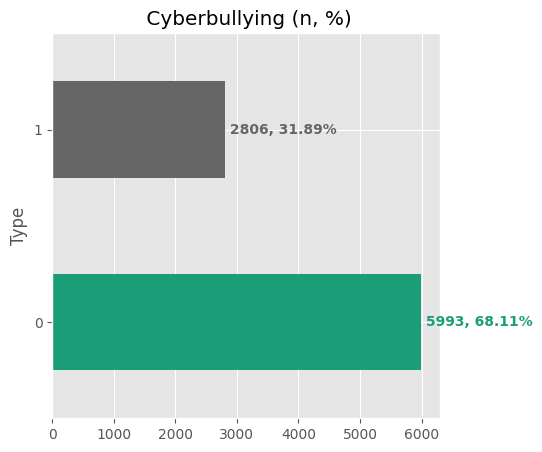

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(df["oh_label"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df['oh_label'].value_counts().plot.barh(title=" Cyberbullying (n, %)",
                                                 ylabel="Type",
                                                 color=colors,
                                                 figsize=(5,5))

for i, v in enumerate(df['oh_label'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%",
           color=c,
           va='center',
           fontweight='bold')

Removing non-numeric,lower case, stopwords

In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['Text'] = df['Text'].apply(preprocess_text)
df.head()

,index,oh_label,Text
0,0,1,fuck dad
1,1,0,really understand point xa0 seems mixing apple...
2,2,0,xc2 xa0majority canadians wrong n nunless supp...
3,3,0,listen dont wan na get married man women dont ...
4,4,0,c xe1c b u1ea1n xu u1ed1ng u0111 u01b0 u1eddng...


#TF-IDF

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)


In [ ]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(train_data['Text'])
X_val_tfidf = vectorizer.transform(val_data['Text'])
X_test_tfidf = vectorizer.transform(test_data['Text'])


# SVC

In [ ]:
from sklearn.svm import SVC

classifier = SVC(probability=True)


In [ ]:
epochs = 3
best_val_accuracy = 0.0
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')


    y_train = train_data['oh_label']
    classifier.fit(X_train_tfidf, y_train)

    y_val = val_data['oh_label']
    y_val_pred = classifier.predict(X_val_tfidf)


    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_classification_rep = classification_report(y_val, y_val_pred)

    val_probabilities = classifier.predict_proba(X_val_tfidf)
    val_log_loss = log_loss(y_val, val_probabilities)
    print(f'Validation Log Loss: {val_log_loss}')

    print('Validation Set Metrics:')
    print(f'Accuracy: {val_accuracy}')
    print('Confusion Matrix:')
    print(val_conf_matrix)
    print('Classification Report:')
    print(val_classification_rep)



X_test = test_data['Text']
y_test = test_data['oh_label']
y_test_pred = classifier.predict(X_test_tfidf)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_rep = classification_report(y_test, y_test_pred)

print('Test Set Metrics:')
print(f'Accuracy: {test_accuracy}')
print('Confusion Matrix:')
print(test_conf_matrix)
print('Classification Report:')
print(test_classification_rep)

Epoch 1/3
Validation Log Loss: 0.44885616524833677
Validation Set Metrics:
Accuracy: 0.7954545454545454
Confusion Matrix:
[[920  44]
 [244 200]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       964
           1       0.82      0.45      0.58       444

    accuracy                           0.80      1408
   macro avg       0.81      0.70      0.72      1408
weighted avg       0.80      0.80      0.78      1408

Epoch 2/3
Validation Log Loss: 0.4490584361107603
Validation Set Metrics:
Accuracy: 0.7954545454545454
Confusion Matrix:
[[920  44]
 [244 200]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       964
           1       0.82      0.45      0.58       444

    accuracy                           0.80      1408
   macro avg       0.81      0.70      0.72      1408
weighted avg       0.80      0.80      0.78      1408

Epoch 3/3
V

# RFC

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
epochs = 3
best_val_accuracy = 0.0
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')

    y_train = train_data['oh_label']
    rf_classifier.fit(X_train_tfidf, y_train)

    y_val = val_data['oh_label']
    y_val_pred = rf_classifier.predict(X_val_tfidf)

    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_classification_rep = classification_report(y_val, y_val_pred)

    val_probabilities = classifier.predict_proba(X_val_tfidf)
    val_log_loss = log_loss(y_val, val_probabilities)
    print(f'Validation Log Loss: {val_log_loss}')

    print('Validation Set Metrics:')
    print(f'Accuracy: {val_accuracy}')
    print('Confusion Matrix:')
    print(val_conf_matrix)
    print('Classification Report:')
    print(val_classification_rep)



X_test = test_data['Text']
y_test = test_data['oh_label']
y_test_pred = rf_classifier.predict(X_test_tfidf)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_rep = classification_report(y_test, y_test_pred)

print('Test Set Metrics:')
print(f'Accuracy: {test_accuracy}')
print('Confusion Matrix:')
print(test_conf_matrix)
print('Classification Report:')
print(test_classification_rep)

Epoch 1/3
Validation Log Loss: 0.4495569645204817
Validation Set Metrics:
Accuracy: 0.7947443181818182
Confusion Matrix:
[[889  75]
 [214 230]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       964
           1       0.75      0.52      0.61       444

    accuracy                           0.79      1408
   macro avg       0.78      0.72      0.74      1408
weighted avg       0.79      0.79      0.78      1408

Epoch 2/3
Validation Log Loss: 0.4495569645204817
Validation Set Metrics:
Accuracy: 0.7947443181818182
Confusion Matrix:
[[889  75]
 [214 230]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       964
           1       0.75      0.52      0.61       444

    accuracy                           0.79      1408
   macro avg       0.78      0.72      0.74      1408
weighted avg       0.79      0.79      0.78      1408

Epoch 3/3
Va

# MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

classifierNB = MultinomialNB()

In [ ]:
epochs = 3
best_val_accuracy = 0.0
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')


    y_train = train_data['oh_label']
    classifierNB.fit(X_train_tfidf, y_train)

    y_val = val_data['oh_label']
    y_val_pred = classifierNB.predict(X_val_tfidf)


    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_classification_rep = classification_report(y_val, y_val_pred)

    val_probabilities = classifierNB.predict_proba(X_val_tfidf)
    val_log_loss = log_loss(y_val, val_probabilities)
    print(f'Validation Log Loss: {val_log_loss}')

    print('Validation Set Metrics:')
    print(f'Accuracy: {val_accuracy}')
    print('Confusion Matrix:')
    print(val_conf_matrix)
    print('Classification Report:')
    print(val_classification_rep)



X_test = test_data['Text']
y_test = test_data['oh_label']
y_test_pred = classifierNB.predict(X_test_tfidf)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_rep = classification_report(y_test, y_test_pred)

print('Test Set Metrics:')
print(f'Accuracy: {test_accuracy}')
print('Confusion Matrix:')
print(test_conf_matrix)
print('Classification Report:')
print(test_classification_rep)

Epoch 1/3
Validation Log Loss: 0.5199014131187717
Validation Set Metrics:
Accuracy: 0.7443181818181818
Confusion Matrix:
[[960   4]
 [356  88]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       964
           1       0.96      0.20      0.33       444

    accuracy                           0.74      1408
   macro avg       0.84      0.60      0.59      1408
weighted avg       0.80      0.74      0.68      1408

Epoch 2/3
Validation Log Loss: 0.5199014131187717
Validation Set Metrics:
Accuracy: 0.7443181818181818
Confusion Matrix:
[[960   4]
 [356  88]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       964
           1       0.96      0.20      0.33       444

    accuracy                           0.74      1408
   macro avg       0.84      0.60      0.59      1408
weighted avg       0.80      0.74      0.68      1408

Epoch 3/3
Va

#KNN

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=93)

In [ ]:
epochs = 3
best_val_accuracy = 0.0

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')

    y_train = train_data['oh_label']
    knn_classifier.fit(X_train_tfidf, y_train)

    y_val = val_data['oh_label']
    y_val_pred = knn_classifier.predict(X_val_tfidf)


    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_classification_rep = classification_report(y_val, y_val_pred)


    val_probabilities = knn_classifier.predict_proba(X_val_tfidf)
    val_log_loss = log_loss(y_val, val_probabilities)
    print(f'Validation Log Loss: {val_log_loss}')

    print('Validation Set Metrics:')
    print(f'Accuracy: {val_accuracy}')
    print('Confusion Matrix:')
    print(val_conf_matrix)
    print('Classification Report:')
    print(val_classification_rep)



X_test = test_data['Text']
y_test = test_data['oh_label']
y_test_pred = knn_classifier.predict(X_test_tfidf)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_rep = classification_report(y_test, y_test_pred)

print('Test Set Metrics:')
print(f'Accuracy: {test_accuracy}')
print('Confusion Matrix:')
print(test_conf_matrix)
print('Classification Report:')
print(test_classification_rep)

Epoch 1/3
Validation Log Loss: 0.511850154402821
Validation Set Metrics:
Accuracy: 0.7571022727272727
Confusion Matrix:
[[955   9]
 [333 111]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.99      0.85       964
           1       0.93      0.25      0.39       444

    accuracy                           0.76      1408
   macro avg       0.83      0.62      0.62      1408
weighted avg       0.80      0.76      0.70      1408

Epoch 2/3
Validation Log Loss: 0.511850154402821
Validation Set Metrics:
Accuracy: 0.7571022727272727
Confusion Matrix:
[[955   9]
 [333 111]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.99      0.85       964
           1       0.93      0.25      0.39       444

    accuracy                           0.76      1408
   macro avg       0.83      0.62      0.62      1408
weighted avg       0.80      0.76      0.70      1408

Epoch 3/3
Vali